# Quantum Phase Estimation (QPE) for Solving Molecular Energies


Quantum Phase Estimation (QPE) is a key algorithm in quantum computing, allowing one to estimate the phase (or eigenvalue) of an eigenvector of a unitary operation. The algorithm is designed so, that for a given Hamiltonian $H$, and an eigenvalue ${|\psi\rangle}$, the output that will be obtained is $\epsilon$ where

$U{|\psi\rangle} = e^{2\pi i\epsilon}{|\psi\rangle} , U = e^{2\pi iH}$ .


Therefore, by measuring the phase accumulated, the QPE algorithm allows calculating the energies relating to the chosen initial state.
When using QPE for chemistry problems, it is common to search for the lowest energy of a given molecule. As the molecule can be written in the form of a Hamiltonian (Hermitian matrix which meaning is the energetic forces of the structure), usually symbolized by "H", one only need to insert the ground eigenvector in order to obtain the minimal energy value using QPE. However, obtaining the ground state is not a trivial problem. In order to overcome it, it is sufficient to use a state with big overlap with the ground state.

We define a state ${|v\rangle}$ which will be chosen as the algorithm's initial state. Let us define {$\psi_i$} to be the set of (unknown) eigenvalues of $H$. Generally, any vector can be rewritten as a superposition of any basis set, thus -

${|v\rangle} = \sum_i a_i{|\psi_i\rangle}$

and -

$U{|v\rangle} = \sum_i a_i e^{2\pi i\epsilon_i}{|\psi_i\rangle}$.

where ${\epsilon_i}$ are the eigenvalues of H, i.e. the span of energies relating to the molecule. Using execution with enough shots, one will obtain this set of $\theta_i$, i.e., a subset of the Hamiltonian's eigenvalues. As we are specifically interested in $\epsilon_0$, the ground state of H, it is important that there is a large overlap between ${\psi_0}$ and ${|v\rangle}$ so the probability to measure ${\epsilon_0}$ is high, i.e.

$P(\epsilon_0) = |\langle v|\psi_0\rangle|^2 > \epsilon $.

How large is $\epsilon$? After execution, we will obtain a set of ${E_i}$.
If we have done 1000 shots of execution, and $P(\epsilon_0)>1$, it should be measured is about 10 times to get a good statistical variance.

A common choice for ${|v\rangle}$ (the initial state) is the Hartree-Fock (HF) state, which with good probability have a large overlap with the ground state. However, other guesses for the initial state are possibly good or even better fit, and choosing the right initial state is a sort of art and an active field of research.

For further reading about QPE we recommend [[1](#NC)].


#### What are the benefits of using QPE algorithm for finding a molecule's ground state?

The two most prominent methods to solve ground energy for molecules are quantum variational algorithm (VQE) and QPE. Those promise better scalability compared to classical counterparts as the molecules becomes more complex, with larger number of electrons manifesting as more degrees of freedom for the problem.

While so, the number of parameters in VQE is closely related to the number of electrons. This may create inherent difficulty achieving high-precision calculations through sampling statistical estimators, and paraphs even not converge for very large systems. While so, the number of parameters in QPE is a flexible value which is directly related to the resolution of the problem, but is not bonded with the number of electrons.

Furthermore, it is known that advanced quantum algorithms based on QPE can perform electronic structure calculations in sub-exponential time with accuracy that rivals exact diagonalization methods. This guarantee of simultaneously achieving high accuracy, efficiency, and generality is a feat that is believed to be impossible for classical algorithms. For those reasons, VQE is applicable in the near term (NISQ) era, while QPE is suited for fault-tolerant design.

#### During this tutorial, we will follow the QPE algorithms steps as following:

a. Define a molecule and convert it into a Hamiltonian H, manifested as a pauli list.

b. Prepare the Hamiltonian for QPE: including normalization and choosing the resolution.

c. Initializing the state for the HF state.

d. Preparing the quantum circuit.

e. Executing the circuit to find the related phases and analyzing the results to find the ground state.

f. Comparing the QPE results with exact solution for the molecule’s ground state.

## 0. Pre-requirments

The model is using several Classiq's libraries in addition to IBM's simulating tool.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy import linalg as LA

# for state preperation and phase estimation
from classiq import Constraints, Preferences

# for chemistry
from classiq.applications.chemistry import Molecule, MoleculeProblem, PauliOperator

## 1. Create Your Molecule

In [2]:
# build your molecule

molecule_H2 = Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, 0.735))])
molecule_O2 = Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, 1.16))])
molecule_LiH = Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, 1.596))])
molecule_H2O = Molecule(
    atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, 0.586, 0.757)), ("H", (0, 0.586, -0.757))]
)
molecule_BeH2 = Molecule(
    atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, 1.334)), ("H", (0, 0, -1.334))]
)

In [3]:
# define your molecule

molecule = molecule_H2

In [4]:
# define your molecule problem

gs_problem = MoleculeProblem(
    molecule=molecule,
    basis="sto3g",
    mapping="jordan_wigner",  #'bravyi_kitaev'
    z2_symmetries=True,
    freeze_core=True,
)

operator = gs_problem.generate_hamiltonian()
gs_problem = gs_problem.update_problem(operator.num_qubits)
print("Your Hamiltonian is", operator.show(), sep="\n")

Your Hamiltonian is
-1.041 * I
-0.796 * Z
+0.181 * X


In [5]:
pauli_ops = operator.pauli_list
N = operator.num_qubits
print("Your Pauli list is", pauli_ops, sep="\n")

Your Pauli list is
[('I', (-1.041093141516624+0j)), ('Z', (-0.7958748496863586+0j)), ('X', (0.18093119978423122+0j))]


## 2. Preparing the Molecule for QPE

### 2.1 Chose the Algorithm's Precision

For QPE algorithms, the precision is set by the number of qubits chosen $n$, such that the resolution is $1/{2^n}$. In case the matrix needs to be normlized, the resolution will be distorted. In case of normalization, that the span of results in the QPE is strached between the lowest and highest possible phase, thus the reslution will be mapped to $normalization-coefficient/{2^n} ~\sim 1/{((\lambda_{max}-\lambda_{min})*2^n)}$.

Here you can chose the precision in the parameter `n_qpe`, or by setting your desired resolution. If you chose your desired resolution and set the parameter `get_recommended_n` to be True, the number of qubits will be calculated for you accordingly.


In [6]:
# `n_qpe`-  The precision of the QPE (the number of qubits to be used in the QPE. Creates resolution of 1/2^n_qpe
n_qpe = 6

In [7]:
# recommanded n_qpe:
get_recommanded_n = False

import math

desired_resolution = 0.02


def get_nqpe(pauli_operator, desired_resolution):
    N = pauli_operator.num_qubits
    A = 0
    for a, b in pauli_operator.pauli_list:
        A = A + abs(b)
    nqpe = math.log2(2 * N * A / desired_resolution)
    return math.ceil(nqpe)


if get_recommanded_n:
    n_qpe = get_nqpe(operator, desired_resolution)
    print("number of qubits for QPE is", n_qpe)

### 2.3 Normalize the Matrix

As QPE obtains a phase in the form $e^{2\pi i\theta}$, there is meaning only for $\theta \in [0,2\pi)$. Generally, our matrix M can have any eigenvalue, thus \theta can have any value. In order to fix this discrepancy, the values of the matrix are stretched to be rescaled. We assume
$\theta \in [\lambda_{min}, \lambda_{max}]$
and use a normalization function in order to map those values into $[0, 1-1/{2^n}]$, where n is the number of qubits chosen for the QPE process in section 2.2.

We perform the normalization procedure as following:

a. We evaluate $\lambda_{min},\lambda_{max}$ (in the function ` normalization_params()` below). In order to do so we use rough estimation of the absolute max value that can take place by adding together all the pauli coefficients and multiplying by the matrix's dimensions. That will yield us a value $\lambda$ (which is referred in the code as `normalization_coeff`) and we now assume that the domain is $\theta \in [-\lambda, \lambda]$.
In general, one can build a more accurate assessment, which will decrease the span of solutions and thus achieve a better resolution.

b. We make sure only positive values are available by adding $\lambda*I^n$ to the pauli list. Now our evaluated span is $[0, 2*\lambda]$.

c. We normlize our matrix by multiplying all of the pauli coefficients by $(1-1/2^n)/(2*\lambda)$. Now the span of $\theta$ is $[0, 1-1/2^n]$, as required for proper QPE process.

The values of the matrix's eigenvalues should be now between $0$ to $1-(1/2^n)$. The QPE procedure will be performed on this new normalized matrix. After the phases are obtained, the original phases of the pre-normalized matrix will be gathered by performing opposite steps to this normalization procedure.

* Note that in case your matrix's eigenvalues are naturally between the values $0$ to $1-(1/2^n)$, you may not want to normalize it, as the normalization procedure may enlarge the span, thus lowering the resolution of the agorithm. In that case, you may skip those lines or change the value `normalize` to False.

In [8]:
from typing import cast

from classiq import Pauli, PauliTerm

# normalizing the operator
## we need to create a matrix such that its normalized version will have eigenvalues of [0,1/2^k] when k is the resolution of the QPE
normalize = True


def normalization_params(pauli_list, N):
    A = 0
    for a, b in pauli_list:
        A = A + abs(b)
    return N * A


def normalize_hamiltonian(pauli_list, normalization_coeff, k):
    new_pauli_list = []
    for a, b in pauli_list:
        if a == "I" * N:
            new_pauli_list.append(
                (
                    a,
                    (b + normalization_coeff)
                    * (1 - 1 / (2**k))
                    / (2 * normalization_coeff),
                )
            )
        else:
            new_pauli_list.append((a, b * (1 - 1 / (2**k)) / (2 * normalization_coeff)))
    return new_pauli_list


pauli_list = pauli_ops
if normalize:
    normalization_coeff = normalization_params(pauli_ops, N)
    new_pauli_list = normalize_hamiltonian(pauli_ops, normalization_coeff, n_qpe)
    pauli_ops = new_pauli_list
    print(pauli_ops)

[('I', (0.23825359047723227+0j)), ('Z', (-0.1941225083639407+0j)), ('X', (0.04413108211329154+0j))]


Convert the objects to qmod:

In [9]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]


def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

## 3. Creating the Quantum Circuit

We will now create a quantum circuit of the QPE algorithm using the Classiq platform. The user is able to fill in their constraints and preferences as desired.

In [10]:
constraints = Constraints()
preferences = Preferences(timeout_seconds=600)

### 3.1. Create the phase estimation model

In [11]:
from classiq import molecule_problem_to_qmod
from classiq.qmod import (
    CInt,
    Output,
    QArray,
    QBit,
    QCallable,
    QNum,
    allocate,
    allocate_num,
    control,
    invert,
    qfunc,
    repeat,
)
from classiq.qmod.builtins import (
    H,
    apply_to_all,
    exponentiation_with_depth_constraint,
    molecule_hartree_fock,
    qft,
)
from classiq.qmod.symbolic import log, pi

# this constant will be multipled be a linear factor for each qbit of the qpe, so the
# depth will scale linear with the power of each unitary, on the expense of approximating the
# exponentiation function
exp_max_depth = 2200


# define a Quantum Phase Estimation function that allows specifying each controlled
# power unitary directly
@qfunc
def my_flexible_qpe(
    unitary_with_power: QCallable[CInt],
    phase: QArray[QBit],
) -> None:
    apply_to_all(H, phase)

    repeat(
        count=phase.len,
        iteration=lambda index: control(
            ctrl=phase[index],
            operand=lambda: unitary_with_power(2**index),
        ),
    )
    invert(lambda: qft(phase))


@qfunc
def main(reg: Output[QArray[QBit]], phase: Output[QNum]):
    allocate_num(num_qubits=n_qpe, is_signed=False, fraction_digits=n_qpe, out=phase)
    allocate(N, reg)

    # The state chosen for the initial state is HF, as usually it has good overlap with the with the eigenstate of minimal energy.
    molecule_hartree_fock(molecule_problem_to_qmod(gs_problem), reg)

    # # Hereby we send the pauli list created for the molecule for creating phase estimation circuit.
    my_flexible_qpe(
        lambda power: exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_ops),
            evolution_coefficient=-2 * np.pi * power,
            max_depth=exp_max_depth * ((2**0.5) ** log(power, 2)),
            qbv=reg,
        ),
        phase,
    )

## 3.2. Synthesizing the Circuit

Hereby we syntesize the circuit and show it using the analyzer.

In [12]:
from classiq import create_model
from classiq.execution import ExecutionPreferences

num_shots = 200000

qmod = create_model(
    main,
    constraints=constraints,
    preferences=preferences,
    execution_preferences=ExecutionPreferences(num_shots=num_shots),
)

In [13]:
from classiq import write_qmod

write_qmod(qmod, name="qpe_for_molecules")

In [14]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/af23ed58-4a51-4e36-bd7b-c0231e048f0b?version=0.38.0.dev42%2Bfd36e2c41c


# 4. Measurment and Analysis


### 4.1. Circuit Execution

The circuit is now sent to execution on a default simulator

In [15]:
from classiq import execute

results = execute(qprog).result()

In [16]:
from classiq.execution import ExecutionDetails

results = results[0].value

### 4.2. Presenting the Result's Count

In [17]:
results.parsed_counts_of_outputs("phase")[:10]

[{'phase': 0.046875}: 82112,
 {'phase': 0.03125}: 77847,
 {'phase': 0.0625}: 9079,
 {'phase': 0.015625}: 8833,
 {'phase': 0.078125}: 3194,
 {'phase': 0.0}: 3157,
 {'phase': 0.4375}: 2555,
 {'phase': 0.09375}: 1679,
 {'phase': 0.984375}: 1634,
 {'phase': 0.109375}: 1010]

### 4.3. Chosing the Most Probable Solution

Hereby the user will choose the number of eigenvalues they wish to extract from the poll of results. The 
value `number_of_solutions` will determine how many results out of `qpe_results` will be analyzed. 
The `parsed_counts` property is already sorted.

We get the result in the `phase` variable already encoded as fixed point variable in the range [0,1].

In [18]:
number_of_solutions = 1  # to be set

In [19]:
solutions = results.parsed_counts_of_outputs("phase")[:number_of_solutions]
print("Your qubit solution is", solutions, sep="\n")

Your qubit solution is
[{'phase': 0.046875}: 82112]


### 4.4. Translating into Energy value (Phase)

Map the phase back into the original values, i.e. renormalized into it's original span.

In [20]:
def post_process_phase(phase):
    return (
        (phase * 2 * normalization_coeff) / (1 - (1 / 2**n_qpe))
    ) - normalization_coeff

In [21]:
# renormalize into the "real" solution -
if normalize:
    solution = [post_process_phase(value.state["phase"]) for value in solutions]
else:
    solution = dec_sol_vec

The final results of the Energy (matrix's eigenvlues) is therefore:

In [22]:
print(solution)

[-1.8257183156550982]


And the results including the error contributed from the resolution (number of qubits participating in the QPE) are:

In [23]:
if normalize:
    energy_resolution = (
        (1 / (2**n_qpe)) * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
    )
else:
    energy_resolution = 1 / (2**n_qpe)

print("the resolution of result is", energy_resolution)

for sol in solution:
    print(
        "the eneregy solution is beteen",
        sol - energy_resolution,
        "and",
        sol + energy_resolution,
    )

    ###if zero or exceed the normalization range need to add conditions

the resolution of result is 0.06406029177737187
the eneregy solution is beteen -1.88977860743247 and -1.7616580238777264


### 4.4. Find Exact Solution for Comparison

In [24]:
mat = operator.to_matrix()
w, v = np.linalg.eig(mat)
print("exact result:", np.real(min(w)))

exact result: -1.8572750302023786


### 4.4. Find the Solution's Histogram

In [25]:
import matplotlib.pyplot as plt
import numpy as np

energy_vec = []
energy_prob = []

for value, counts in results.parsed_counts_of_outputs("phase"):
    temp = value[1]["phase"]
    if normalize:
        temp2 = (
            temp * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
        ) - normalization_coeff
    else:
        temp2 = temp
    energy_vec.append(temp2)
    energy_prob.append(counts[1] / num_shots)

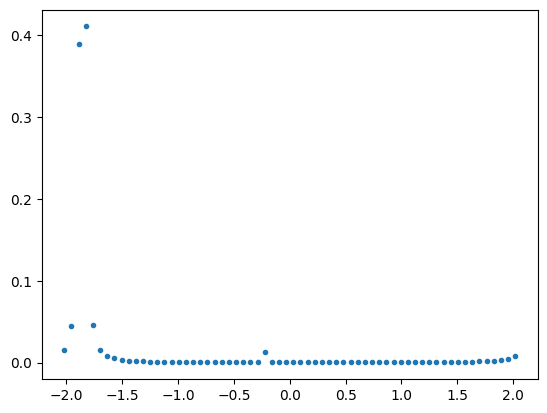

In [26]:
plt.plot(energy_vec, energy_prob, ".")
plt.show()

## References

<a name='NC'>[1]</a>: [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, New York, NY, USA.
](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf)
